In [1]:
# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict


import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import os
import gdown

In [2]:
# This line downloads shoe images
gdown.download('https://drive.google.com/uc?id=1j1gmdpwLydYjpqbUQJAuSmT5WW9WoOx-', 'shoes.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1j1gmdpwLydYjpqbUQJAuSmT5WW9WoOx-
To: /content/shoes.zip
792MB [00:04, 188MB/s]


'shoes.zip'

In [ ]:
!unzip -qq shoes.zip

In [4]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
data_dir = 'shoes'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [7]:
# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# Using the image datasets and the trainforms, define the dataloaders
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
class_names

['andrew',
 'aziz',
 'cody',
 'jill',
 'kayla',
 'lilly',
 'ramya_g',
 'ramya_p',
 'rohan',
 'sai',
 'sam',
 'shashank',
 'shivani',
 'sirisha',
 'swathi',
 'vijay']

In [9]:
print(dataset_sizes)
print(device)

{'train': 249, 'valid': 81}
cuda:0


In [10]:
model_name = 'densenet' #vgg
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [11]:
# Create classifier
for param in model.parameters():
    param.requires_grad = False

def build_classifier(num_in_features, hidden_layers, num_out_features):
   
    classifier = nn.Sequential()
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, num_out_features))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        classifier.add_module('relu1', nn.ReLU())
        classifier.add_module('drop1', nn.Dropout(.5))
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [12]:
hidden_layers = None#[4096, 1024, 256][512, 256, 128]

classifier = build_classifier(num_in_features, hidden_layers, len(class_names))
print(classifier)

 # Only train the classifier parameters, feature parameters are frozen
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    #optimizer_conv = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.001, momentum=0.9)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
else:
    pass

Sequential(
  (fc0): Linear(in_features=2208, out_features=16, bias=True)
)


In [13]:
# Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, sched, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [14]:
epochs = 10
model.to(device)
model = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/10
----------
train Loss: 2.8886 Acc: 0.1245
valid Loss: 2.2826 Acc: 0.3086

Epoch 2/10
----------
train Loss: 2.1942 Acc: 0.3896
valid Loss: 1.6285 Acc: 0.5432

Epoch 3/10
----------
train Loss: 1.7840 Acc: 0.4538
valid Loss: 1.1851 Acc: 0.7778

Epoch 4/10
----------
train Loss: 1.3213 Acc: 0.6586
valid Loss: 0.9963 Acc: 0.8272

Epoch 5/10
----------
train Loss: 1.0568 Acc: 0.7952
valid Loss: 0.8341 Acc: 0.8025

Epoch 6/10
----------
train Loss: 0.8684 Acc: 0.7992
valid Loss: 0.5762 Acc: 0.9630

Epoch 7/10
----------
train Loss: 0.7132 Acc: 0.9277
valid Loss: 0.4541 Acc: 0.9753

Epoch 8/10
----------
train Loss: 0.4792 Acc: 0.9759
valid Loss: 0.3551 Acc: 0.9753

Epoch 9/10
----------
train Loss: 0.4832 Acc: 0.9558
valid Loss: 0.3510 Acc: 0.9753

Epoch 10/10
----------
train Loss: 0.3744 Acc: 0.9598
valid Loss: 0.2846 Acc: 0.9753

Training complete in 13m 20s
Best val Acc: 0.975309


In [15]:
# Evaluation

model.eval()

accuracy = 0

for inputs, labels in dataloaders['valid']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    # Class with the highest probability is our predicted class
    equality = (labels.data == outputs.max(1)[1])

    # Accuracy is number of correct predictions divided by all predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    
print("Test accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

Test accuracy: 0.984


In [16]:
# Saving the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx

In [17]:
checkpoint = {'input_size': 2208,
              'output_size': len(class_names),
              'epochs': epochs,
              'batch_size': 64,
              'model': models.densenet161(pretrained=True),
              'classifier': classifier,
              'scheduler': sched,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
   
torch.save(checkpoint, 'checkpoint_shoes_d161.pth')

In [18]:
# Loading the checkpoint
ckpt = torch.load('checkpoint_shoes_d161.pth')
ckpt.keys()

dict_keys(['input_size', 'output_size', 'epochs', 'batch_size', 'model', 'classifier', 'scheduler', 'optimizer', 'state_dict', 'class_to_idx'])

In [19]:
# Load a checkpoint and rebuild the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model, checkpoint['class_to_idx']

In [20]:
model, class_to_idx = load_checkpoint('checkpoint_shoes_d161.pth')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [21]:
idx_to_class = { v : k for k,v in class_to_idx.items()}

## Inference for Classification
### Image Preprocessing

In [24]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image

In [22]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

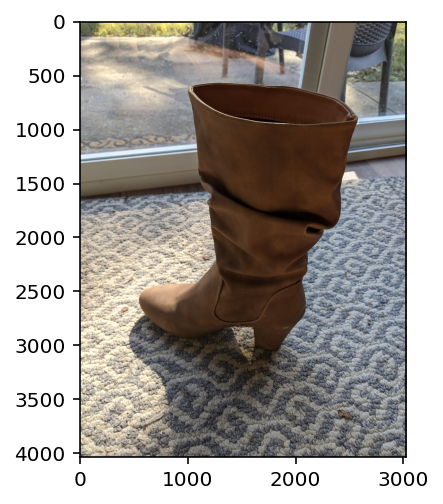

In [23]:
# image_path = 'shoes/valid/sai/17126c61-991a-42b7-a7ba-8e4ac39ee639.JPG'
# image_path = 'shoes/valid/rohan/PXL_20201125_214936130~2.jpg'  # dark rohan or kayla?
# image_path = 'shoes/train/rohan/PXL_20201125_215221819.jpg'  # rohan
image_path = 'shoes/train/kayla/PXL_20201120_160855308.jpg'
#image_path = 'shoes/train/ramya_p/20201125_184555.jpg'
with Image.open(image_path) as image:
    plt.imshow(image)

## Class Prediction

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
model.class_to_idx = image_datasets['train'].class_to_idx

In [27]:
def predict2(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

In [28]:
probs, classes = predict2(image_path, model.to(device))
print(probs)
print(classes)
print([class_names[e] for e in classes])

[0.9631245732307434, 0.006022821646183729, 0.005963730625808239, 0.004613692872226238, 0.003402751637622714]
[4, 8, 6, 11, 12]
['kayla', 'rohan', 'ramya_g', 'shashank', 'shivani']


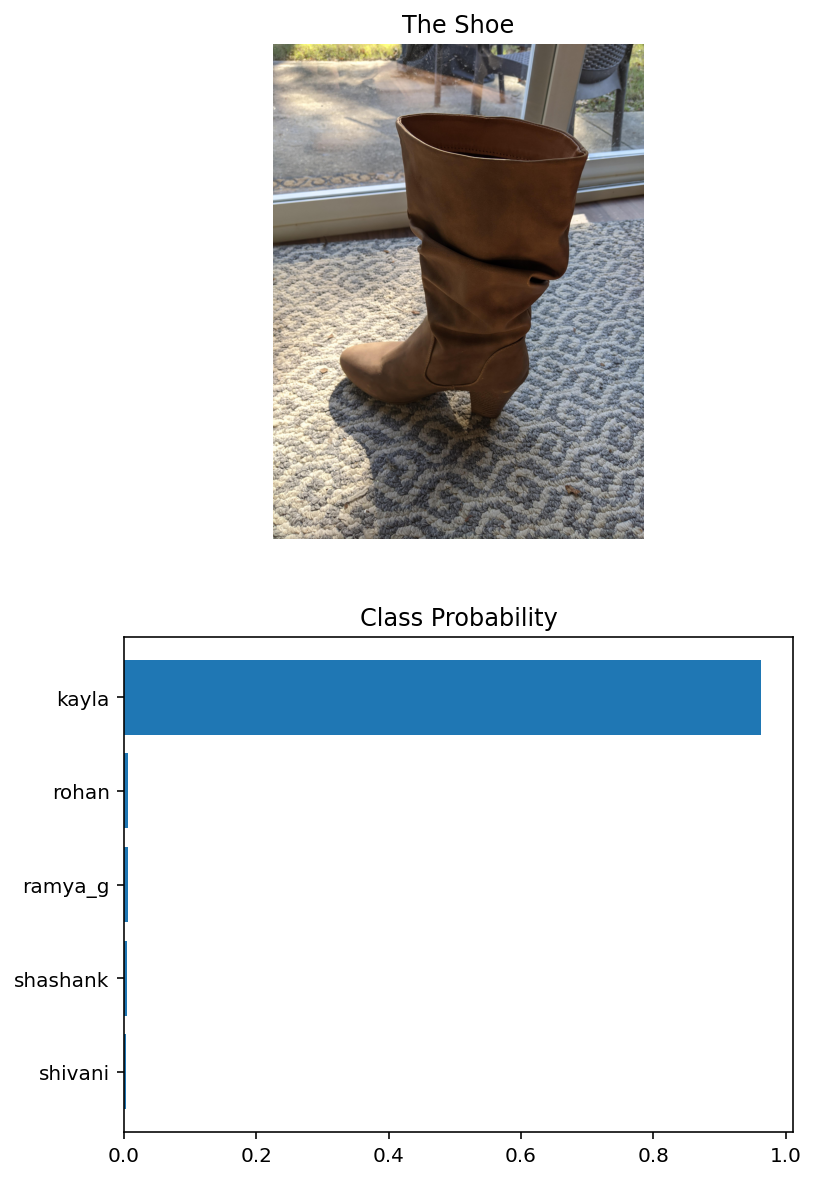

In [29]:
def view_classify(img_path, prob, classes, mapping):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    #class_name = mapping[img_path.split('/')[-2]]
    ax1.set_title('The Shoe')
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([class_names[e] for e in classes])
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')

view_classify(image_path, probs, classes, class_names)

In [30]:
# Inspect the layers in our DenseNet
for module_pos, module in model.features._modules.items():
    print(module_pos)

conv0
norm0
relu0
pool0
denseblock1
transition1
denseblock2
transition2
denseblock3
transition3
denseblock4
norm5


# Here we experiment with GradCAM to see where the model is focused

In [31]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 3.6MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp37-none-any.whl size=5269 sha256=8f440366535f281205436d551aabdaaabf426b7a7b17c4dec55ff766e8e1638f
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [32]:
from gradcam.utils import visualize_cam
import torchvision.models as models
from gradcam import GradCAMpp
gradcam_pp = GradCAMpp.from_config(model_type='densenet', arch=models.densenet161(pretrained=True), layer_name='features_norm5')

In [33]:
# This code runs w/model on the cpu...
device = "cpu"
# image_to_check = Image.open('shoes/train/rohan/PXL_20201125_215642586~2.jpg').convert('RGB')  # shoe on stick
# image_to_check = Image.open('shoes/train/rohan/PXL_20201125_220257973.jpg').convert('RGB')  # rohan or kayla?
# image_to_check = Image.open('shoes/train/rohan/PXL_20201125_214059199.jpg').convert('RGB')  # shoe on blanket
image_to_check = Image.open('shoes/train/ramya_p/20201125_184555.jpg').convert('RGB')  # 

In [34]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(image_to_check).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [35]:
mask_pp, _ = gradcam_pp(normed_torch_img)
heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
images = [torch_img.cpu(), heatmap_pp, result_pp]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


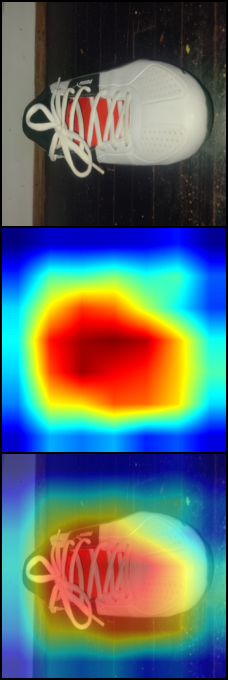

In [36]:
from torchvision.utils import make_grid
grid_image = make_grid(images, nrow=1)
transforms.ToPILImage()(grid_image)